In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import pickle
import scipy.stats

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
colors = ['#4CAF50', '#FFEB3B', '#FF9800', '#F44336']

In [3]:
def ci(samples, level=0.95, axis=0):
    # https://en.wikipedia.org/wiki/Confidence_interval#Basic_steps
    # https://stackoverflow.com/a/15034143/6826667
    num_samples = samples.shape[axis]
    mean = np.mean(samples, axis=axis)
    
    # Standard error of the mean
    se = scipy.stats.sem(samples, axis=0)
    
    # Critical value from standard Student t table
    t = scipy.stats.t.ppf(0.5 * (1 + level), num_samples - 1)
    
    # Confidence interval t_{alpha, n-1} * sigma / sqrt(n)
    interval = t * se

    return (mean - interval, mean + interval)

In [4]:
def get_states(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    mapping = {'S': 0, 'E': 1, 'I': 2, 'R': 3, 'N/A': -1}

    humans_state = data['humans_state']
    names = list(humans_state.keys())
    num_days = len(humans_state[names[0]])
    states = np.zeros((len(names), num_days), dtype=np.int_)
    
    for i, name in enumerate(names):
        states[i] = np.asarray([mapping[state] for state in humans_state[name]], dtype=np.int_)
    assert np.all(states >= 0)
    
    bincount = lambda x: np.bincount(x, minlength=4)
    return np.apply_along_axis(bincount, axis=0, arr=states) / len(names)

In [5]:
def get_all_states(filenames):
    states = get_states(filenames[0])
    all_states = np.zeros((len(filenames),) + states.shape, dtype=states.dtype)
    all_states[0] = states
    
    for i, filename in enumerate(filenames[1:]):
        all_states[i + 1] = get_states(filename)

    return all_states

In [6]:
def get_rec_levels(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    humans_rec_level = data['humans_rec_level']
    intervention_day = data['intervention_day']
    names = list(humans_rec_level.keys())
    num_days = len(humans_rec_level[names[0]])
    rec_levels = np.zeros((len(names), num_days), dtype=np.int_)
    for i, name in enumerate(names):
        rec_levels[i] = np.asarray(humans_rec_level[name], dtype=np.int_)
    rec_levels = rec_levels[:, intervention_day:]
    bincount = lambda x: np.bincount(x, minlength=4)

    return np.apply_along_axis(bincount, axis=0, arr=rec_levels) / len(names)

In [7]:
def get_all_rec_levels(filenames):
    rec_levels = get_rec_levels(filenames[0])
    all_rec_levels = np.zeros((len(filenames),) + rec_levels.shape, dtype=rec_levels.dtype)
    all_rec_levels[0] = rec_levels
    
    for i, filename in enumerate(filenames[1:]):
        all_rec_levels[i + 1] = get_rec_levels(filename)

    return all_rec_levels

In [8]:
def get_intervention_levels(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    humans_rec_level = data['humans_intervention_level']
    intervention_day = data['intervention_day']
    names = list(humans_rec_level.keys())
    num_days = len(humans_rec_level[names[0]])
    rec_levels = np.zeros((len(names), num_days), dtype=np.int_)
    for i, name in enumerate(names):
        rec_levels[i] = np.asarray(humans_rec_level[name], dtype=np.int_)
    rec_levels = rec_levels[:, intervention_day:]
    bincount = lambda x: np.bincount(x, minlength=4)

    return np.apply_along_axis(bincount, axis=0, arr=rec_levels) / len(names)

In [9]:
def get_all_intervention_levels(filenames):
    intervention_levels = get_intervention_levels(filenames[0])
    all_intervention_levels = np.zeros((len(filenames),) + intervention_levels.shape, dtype=intervention_levels.dtype)
    all_intervention_levels[0] = intervention_levels
    
    for i, filename in enumerate(filenames[1:]):
        all_intervention_levels[i + 1] = get_intervention_levels(filename)

    return all_intervention_levels

## Comparison Heuristic v1 vs Heuristic v2

In [10]:
heuristicv1 = glob.glob('../2020-06-03/heuristicv1/*/*.pkl')
heuristicv2 = glob.glob('../2020-06-03/heuristicv2/*/*.pkl')

In [11]:
heuristicv1_states = get_all_states(heuristicv1)
heuristicv2_states = get_all_states(heuristicv2)

In [12]:
heuristicv1_rec_levels = get_all_rec_levels(heuristicv1)
heuristicv2_rec_levels = get_all_rec_levels(heuristicv2)

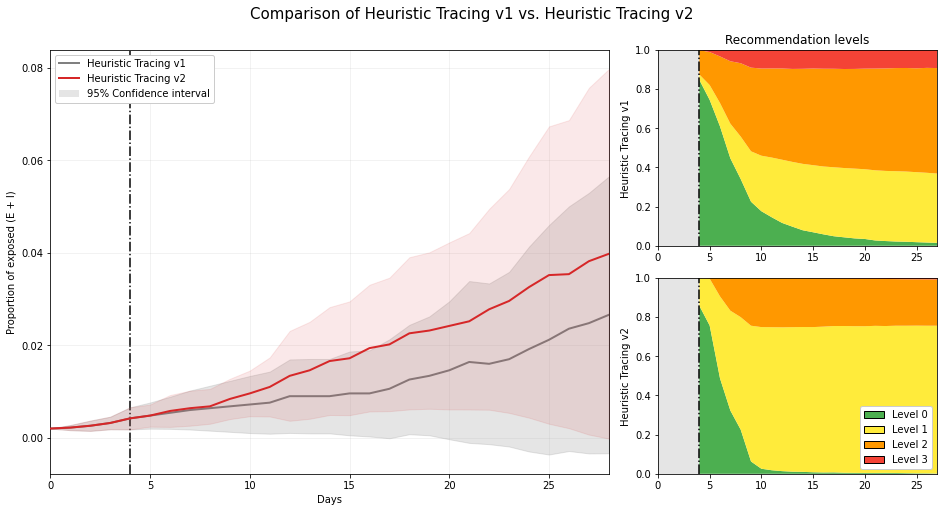

In [13]:
mean_heuristicv1_states = np.mean(heuristicv1_states[:, 1:3].sum(1), axis=0) # E + I
mean_heuristicv2_states = np.mean(heuristicv2_states[:, 1:3].sum(1), axis=0)

mean_heuristicv1_rec_levels = np.mean(heuristicv1_rec_levels, axis=0)
mean_heuristicv2_rec_levels = np.mean(heuristicv2_rec_levels, axis=0)

fig = plt.figure(figsize=(13, 7), constrained_layout=True)

gridspec = fig.add_gridspec(2, 3)

# Proportion of exposed plot
ax0 = fig.add_subplot(gridspec[:, :2])
ax0.grid(alpha=0.2, zorder=0)

legend_handles = [
    Line2D([0], [0], color='gray', lw=2, label='Heuristic Tracing v1'),
    Line2D([0], [0], color='C3', lw=2, label='Heuristic Tracing v2'),
    Patch(facecolor='gray', alpha=0.2, label='95% Confidence interval')
]

ax0.plot(mean_heuristicv1_states, c='gray', zorder=2, lw=2, label='Heuristic Tracing v1')
ax0.fill_between(np.arange(mean_heuristicv1_states.shape[0]),
                *ci(heuristicv1_states[:, 1:3].sum(1), level=0.95, axis=0),
                color='gray', alpha=0.2, zorder=1)

ax0.plot(mean_heuristicv2_states, c='C3', zorder=4, lw=2, label='Heuristic Tracing v2')
ax0.fill_between(np.arange(mean_heuristicv2_states.shape[0]),
                *ci(heuristicv2_states[:, 1:3].sum(1), level=0.95, axis=0),
                color='C3', alpha=0.1, zorder=3)

ax0.set_xlim(0, 28)
ax0.axvline(4, c='k', ls='-.', zorder=0)
ax0.legend(handles=legend_handles, loc='upper left', framealpha=1.0)
ax0.set_xlabel('Days')
ax0.set_ylabel('Proportion of exposed (E + I)')

# Mobility Heuristic v1
legend_handles = [Patch(facecolor=color, edgecolor='k', label=f'Level {level}')
                  for (level, color) in enumerate(colors)]

ax1 = fig.add_subplot(gridspec[0, 2])
ax1.stackplot(np.arange(4, 4 + mean_heuristicv1_rec_levels.shape[1]),
              mean_heuristicv1_rec_levels, colors=colors)
ax1.axvspan(0, 4, fc='gray', alpha=0.2)
ax1.axvline(4, c='k', ls='-.')
ax1.margins(0, 0)
ax1.set_title('Recommendation levels')
ax1.set_ylabel('Heuristic Tracing v1')

# Mobility Heuristic v2
ax2 = fig.add_subplot(gridspec[1, 2])
ax2.stackplot(np.arange(4, 4 + mean_heuristicv2_rec_levels.shape[1]),
              mean_heuristicv2_rec_levels, colors=colors)
ax2.axvspan(0, 4, fc='gray', alpha=0.2)
ax2.axvline(4, c='k', ls='-.')
ax2.margins(0, 0)
ax2.set_ylabel('Heuristic Tracing v2')
ax2.legend(handles=legend_handles, loc='lower right', framealpha=1.0)

plt.suptitle('Comparison of Heuristic Tracing v1 vs. Heuristic Tracing v2', size=15)

plt.show()

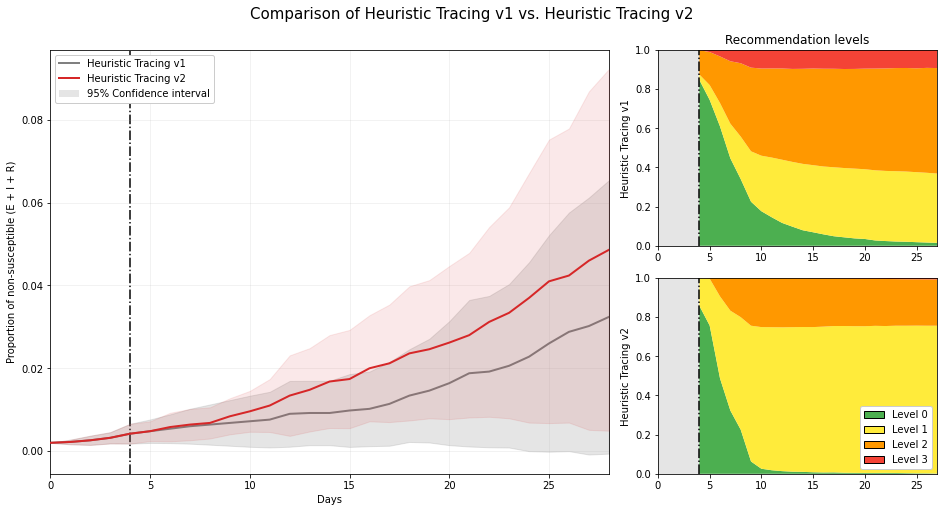

In [14]:
mean_heuristicv1_states = np.mean(heuristicv1_states[:, 1:4].sum(1), axis=0) # E + I + R
mean_heuristicv2_states = np.mean(heuristicv2_states[:, 1:4].sum(1), axis=0)

mean_heuristicv1_rec_levels = np.mean(heuristicv1_rec_levels, axis=0)
mean_heuristicv2_rec_levels = np.mean(heuristicv2_rec_levels, axis=0)

fig = plt.figure(figsize=(13, 7), constrained_layout=True)

gridspec = fig.add_gridspec(2, 3)

# Proportion of exposed plot
ax0 = fig.add_subplot(gridspec[:, :2])
ax0.grid(alpha=0.2, zorder=0)

legend_handles = [
    Line2D([0], [0], color='gray', lw=2, label='Heuristic Tracing v1'),
    Line2D([0], [0], color='C3', lw=2, label='Heuristic Tracing v2'),
    Patch(facecolor='gray', alpha=0.2, label='95% Confidence interval')
]

ax0.plot(mean_heuristicv1_states, c='gray', zorder=2, lw=2, label='Heuristic Tracing v1')
ax0.fill_between(np.arange(mean_heuristicv1_states.shape[0]),
                *ci(heuristicv1_states[:, 1:4].sum(1), level=0.95, axis=0),
                color='gray', alpha=0.2, zorder=1)

ax0.plot(mean_heuristicv2_states, c='C3', zorder=4, lw=2, label='Heuristic Tracing v2')
ax0.fill_between(np.arange(mean_heuristicv2_states.shape[0]),
                *ci(heuristicv2_states[:, 1:4].sum(1), level=0.95, axis=0),
                color='C3', alpha=0.1, zorder=3)

ax0.set_xlim(0, 28)
ax0.axvline(4, c='k', ls='-.', zorder=0)
ax0.legend(handles=legend_handles, loc='upper left', framealpha=1.0)
ax0.set_xlabel('Days')
ax0.set_ylabel('Proportion of non-susceptible (E + I + R)')

# Mobility Heuristic v1
legend_handles = [Patch(facecolor=color, edgecolor='k', label=f'Level {level}')
                  for (level, color) in enumerate(colors)]

ax1 = fig.add_subplot(gridspec[0, 2])
ax1.stackplot(np.arange(4, 4 + mean_heuristicv1_rec_levels.shape[1]),
              mean_heuristicv1_rec_levels, colors=colors)
ax1.axvspan(0, 4, fc='gray', alpha=0.2)
ax1.axvline(4, c='k', ls='-.')
ax1.margins(0, 0)
ax1.set_title('Recommendation levels')
ax1.set_ylabel('Heuristic Tracing v1')

# Mobility Heuristic v2
ax2 = fig.add_subplot(gridspec[1, 2])
ax2.stackplot(np.arange(4, 4 + mean_heuristicv2_rec_levels.shape[1]),
              mean_heuristicv2_rec_levels, colors=colors)
ax2.axvspan(0, 4, fc='gray', alpha=0.2)
ax2.axvline(4, c='k', ls='-.')
ax2.margins(0, 0)
ax2.set_ylabel('Heuristic Tracing v2')
ax2.legend(handles=legend_handles, loc='lower right', framealpha=1.0)

plt.suptitle('Comparison of Heuristic Tracing v1 vs. Heuristic Tracing v2', size=15)

plt.show()

## Comparison Heuristic (v1) vs Binary Digital Tracing (same mobility)

In [15]:
bdt1_2_heuristic = glob.glob('../2020-06-02/transport-bdt1-heuristic/*/*.pkl')
bdt2_2_heuristic = glob.glob('../2020-06-02/transport-bdt2-heuristic/*/*.pkl')
heuristic = glob.glob('../2020-06-02/heuristic/*/*.pkl')
# QKFIX: Remove seed 1006 (unavailable for BDT)
heuristic = [filename for filename in heuristic if 'seed-1006' not in filename]

In [16]:
bdt1_2_heuristic_states = get_all_states(bdt1_2_heuristic)
bdt2_2_heuristic_states = get_all_states(bdt2_2_heuristic)
heuristic_states = get_all_states(heuristic)

In [17]:
heuristic_rec_levels = get_all_rec_levels(heuristic)
bdt1_intervention_levels = get_all_intervention_levels(bdt1_2_heuristic)
bdt2_intervention_levels = get_all_intervention_levels(bdt2_2_heuristic)

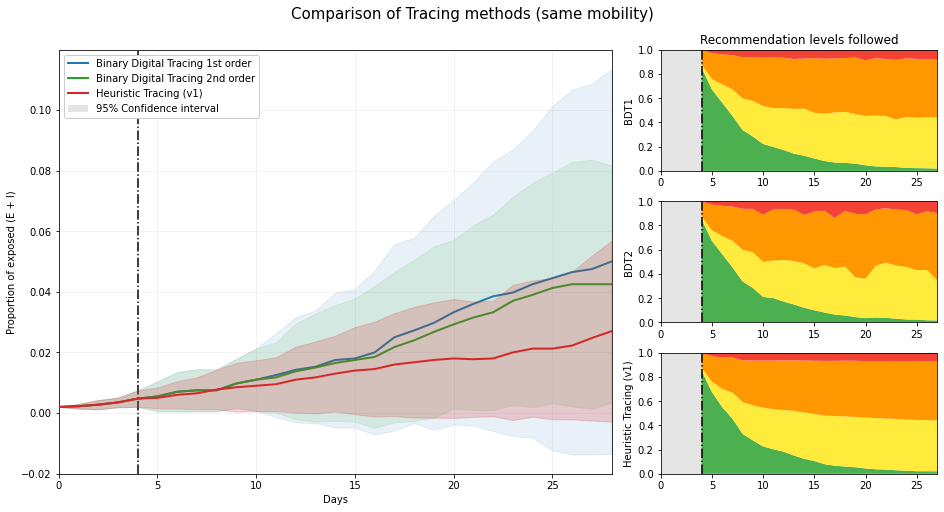

In [18]:
mean_heuristic_states = np.mean(heuristic_states[:, 1:3].sum(1), axis=0) # E + I
mean_bdt1_2_heuristic_states = np.mean(bdt1_2_heuristic_states[:, 1:3].sum(1), axis=0)
mean_bdt2_2_heuristic_states = np.mean(bdt2_2_heuristic_states[:, 1:3].sum(1), axis=0)

mean_heuristic_rec_levels = np.mean(heuristic_rec_levels, axis=0)
mean_bdt1_intervention_levels = np.mean(bdt1_intervention_levels, axis=0)
mean_bdt2_intervention_levels = np.mean(bdt2_intervention_levels, axis=0)

fig = plt.figure(figsize=(13, 7), constrained_layout=True)

gridspec = fig.add_gridspec(3, 3)

# Proportion of exposed plot
ax0 = fig.add_subplot(gridspec[:, :2])

ax0.grid(alpha=0.2, zorder=0)

legend_handles = [
    Line2D([0], [0], color='C0', lw=2, label='Binary Digital Tracing 1st order'),
    Line2D([0], [0], color='C2', lw=2, label='Binary Digital Tracing 2nd order'),
    Line2D([0], [0], color='C3', lw=2, label='Heuristic Tracing (v1)'),
    Patch(facecolor='gray', alpha=0.2, label='95% Confidence interval')
]

ax0.plot(mean_heuristic_states, c='C3', zorder=6, lw=2)
ax0.fill_between(np.arange(mean_heuristic_states.shape[0]),
                *ci(heuristic_states[:, 1:3].sum(1), level=0.95, axis=0),
                color='C3', alpha=0.2, zorder=5)

ax0.plot(mean_bdt1_2_heuristic_states, c='C0', zorder=2, lw=2)
ax0.fill_between(np.arange(mean_bdt1_2_heuristic_states.shape[0]),
                *ci(bdt1_2_heuristic_states[:, 1:3].sum(1), level=0.95, axis=0),
                color='C0', alpha=0.1, zorder=1)

ax0.plot(mean_bdt2_2_heuristic_states, c='C2', zorder=4, lw=2)
ax0.fill_between(np.arange(mean_bdt2_2_heuristic_states.shape[0]),
                *ci(bdt2_2_heuristic_states[:, 1:3].sum(1), level=0.95, axis=0),
                color='C2', alpha=0.1, zorder=3)

ax0.set_xlim(0, 28)
ax0.axvline(4, c='k', ls='-.', zorder=0)
ax0.legend(handles=legend_handles, loc='upper left', framealpha=1.0)
ax0.set_xlabel('Days')
ax0.set_ylabel('Proportion of exposed (E + I)')

# Mobility BDT1
legend_handles = [Patch(facecolor=color, edgecolor='k', label=f'Level {level}')
                  for (level, color) in enumerate(colors)]

ax1 = fig.add_subplot(gridspec[0, 2])
ax1.stackplot(np.arange(4, 4 + mean_bdt1_intervention_levels.shape[1]),
              mean_bdt1_intervention_levels, colors=colors)
ax1.axvspan(0, 4, fc='gray', alpha=0.2)
ax1.axvline(4, c='k', ls='-.')
ax1.margins(0, 0)
ax1.set_title('Recommendation levels followed')
ax1.set_ylabel('BDT1')

# Mobility BDT2
ax2 = fig.add_subplot(gridspec[1, 2])
ax2.stackplot(np.arange(4, 4 + mean_bdt2_intervention_levels.shape[1]),
              mean_bdt2_intervention_levels, colors=colors)
ax2.axvspan(0, 4, fc='gray', alpha=0.2)
ax2.axvline(4, c='k', ls='-.')
ax2.margins(0, 0)
ax2.set_ylabel('BDT2')

# Mobility Heuristic v2
ax3 = fig.add_subplot(gridspec[2, 2])
ax3.stackplot(np.arange(4, 4 + mean_heuristic_rec_levels.shape[1]),
              mean_heuristic_rec_levels, colors=colors)
ax3.axvspan(0, 4, fc='gray', alpha=0.2)
ax3.axvline(4, c='k', ls='-.')
ax3.margins(0, 0)
ax3.set_ylabel('Heuristic Tracing (v1)')
#ax3.legend(handles=legend_handles, loc='lower right', framealpha=1.0)

plt.suptitle('Comparison of Tracing methods (same mobility)', size=15)

plt.show()

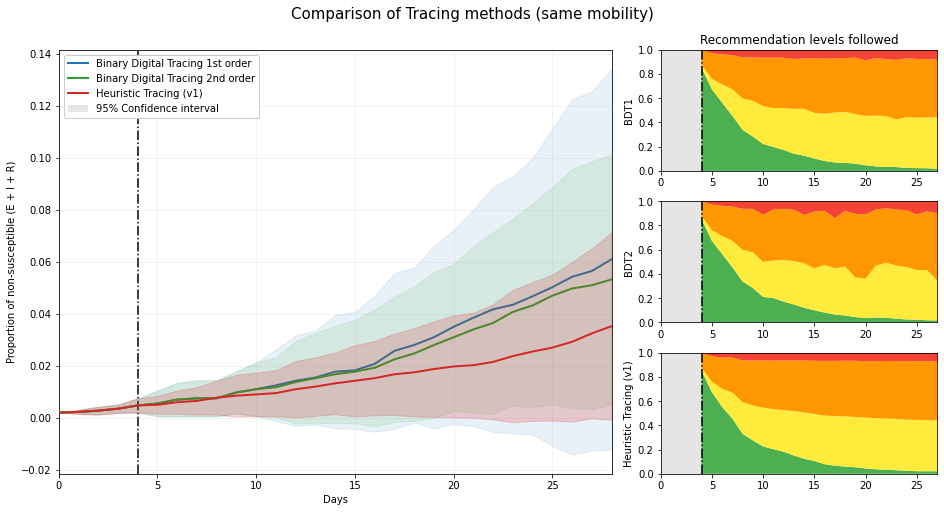

In [19]:
mean_heuristic_states = np.mean(heuristic_states[:, 1:4].sum(1), axis=0) # E + I + R
mean_bdt1_2_heuristic_states = np.mean(bdt1_2_heuristic_states[:, 1:4].sum(1), axis=0)
mean_bdt2_2_heuristic_states = np.mean(bdt2_2_heuristic_states[:, 1:4].sum(1), axis=0)

mean_heuristic_rec_levels = np.mean(heuristic_rec_levels, axis=0)
mean_bdt1_intervention_levels = np.mean(bdt1_intervention_levels, axis=0)
mean_bdt2_intervention_levels = np.mean(bdt2_intervention_levels, axis=0)

fig = plt.figure(figsize=(13, 7), constrained_layout=True)

gridspec = fig.add_gridspec(3, 3)

# Proportion of exposed plot
ax0 = fig.add_subplot(gridspec[:, :2])

ax0.grid(alpha=0.2, zorder=0)

legend_handles = [
    Line2D([0], [0], color='C0', lw=2, label='Binary Digital Tracing 1st order'),
    Line2D([0], [0], color='C2', lw=2, label='Binary Digital Tracing 2nd order'),
    Line2D([0], [0], color='C3', lw=2, label='Heuristic Tracing (v1)'),
    Patch(facecolor='gray', alpha=0.2, label='95% Confidence interval')
]

ax0.plot(mean_heuristic_states, c='C3', zorder=6, lw=2)
ax0.fill_between(np.arange(mean_heuristic_states.shape[0]),
                *ci(heuristic_states[:, 1:4].sum(1), level=0.95, axis=0),
                color='C3', alpha=0.2, zorder=5)

ax0.plot(mean_bdt1_2_heuristic_states, c='C0', zorder=2, lw=2)
ax0.fill_between(np.arange(mean_bdt1_2_heuristic_states.shape[0]),
                *ci(bdt1_2_heuristic_states[:, 1:4].sum(1), level=0.95, axis=0),
                color='C0', alpha=0.1, zorder=1)

ax0.plot(mean_bdt2_2_heuristic_states, c='C2', zorder=4, lw=2)
ax0.fill_between(np.arange(mean_bdt2_2_heuristic_states.shape[0]),
                *ci(bdt2_2_heuristic_states[:, 1:4].sum(1), level=0.95, axis=0),
                color='C2', alpha=0.1, zorder=3)

ax0.set_xlim(0, 28)
ax0.axvline(4, c='k', ls='-.', zorder=0)
ax0.legend(handles=legend_handles, loc='upper left', framealpha=1.0)
ax0.set_xlabel('Days')
ax0.set_ylabel('Proportion of non-susceptible (E + I + R)')

# Mobility BDT1
legend_handles = [Patch(facecolor=color, edgecolor='k', label=f'Level {level}')
                  for (level, color) in enumerate(colors)]

ax1 = fig.add_subplot(gridspec[0, 2])
ax1.stackplot(np.arange(4, 4 + mean_bdt1_intervention_levels.shape[1]),
              mean_bdt1_intervention_levels, colors=colors)
ax1.axvspan(0, 4, fc='gray', alpha=0.2)
ax1.axvline(4, c='k', ls='-.')
ax1.margins(0, 0)
ax1.set_title('Recommendation levels followed')
ax1.set_ylabel('BDT1')

# Mobility BDT2
ax2 = fig.add_subplot(gridspec[1, 2])
ax2.stackplot(np.arange(4, 4 + mean_bdt2_intervention_levels.shape[1]),
              mean_bdt2_intervention_levels, colors=colors)
ax2.axvspan(0, 4, fc='gray', alpha=0.2)
ax2.axvline(4, c='k', ls='-.')
ax2.margins(0, 0)
ax2.set_ylabel('BDT2')

# Mobility Heuristic v2
ax3 = fig.add_subplot(gridspec[2, 2])
ax3.stackplot(np.arange(4, 4 + mean_heuristic_rec_levels.shape[1]),
              mean_heuristic_rec_levels, colors=colors)
ax3.axvspan(0, 4, fc='gray', alpha=0.2)
ax3.axvline(4, c='k', ls='-.')
ax3.margins(0, 0)
ax3.set_ylabel('Heuristic Tracing (v1)')
#ax3.legend(handles=legend_handles, loc='lower right', framealpha=1.0)

plt.suptitle('Comparison of Tracing methods (same mobility)', size=15)

plt.show()

## Comparison mobility

In [20]:
bdt1 = glob.glob('../2020-06-02/binary1/*/*.pkl')
# QKFIX: Remove seed 1006
bdt1 = [filename for filename in bdt1 if 'seed-1006' not in filename]
bdt2 = glob.glob('../2020-06-02/binary2/*/*.pkl')
# QKFIX: Remove seed 1006
bdt2 = [filename for filename in bdt2 if 'seed-1006' not in filename]

In [21]:
bdt1_states = get_all_states(bdt1)
bdt2_states = get_all_states(bdt2)

In [22]:
bdt1_rec_levels = get_all_rec_levels(bdt1)
bdt2_rec_levels = get_all_rec_levels(bdt2)

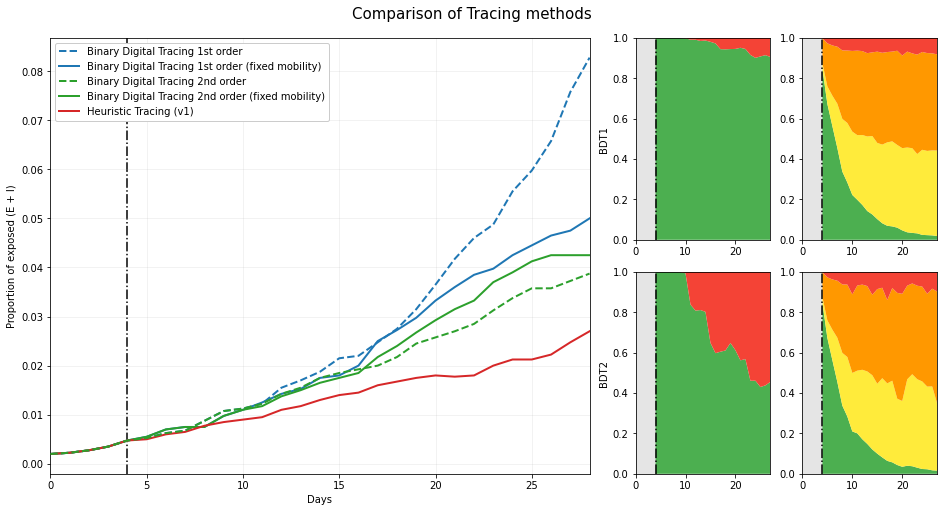

In [23]:
mean_bdt1_states = np.mean(bdt1_states[:, 1:3].sum(1), axis=0) # E + I
mean_bdt2_states = np.mean(bdt2_states[:, 1:3].sum(1), axis=0)
mean_heuristic_states = np.mean(heuristic_states[:, 1:3].sum(1), axis=0)

mean_bdt1_2_heuristic_states = np.mean(bdt1_2_heuristic_states[:, 1:3].sum(1), axis=0)
mean_bdt2_2_heuristic_states = np.mean(bdt2_2_heuristic_states[:, 1:3].sum(1), axis=0)

mean_bdt1_intervention_levels = np.mean(bdt1_intervention_levels, axis=0)
mean_bdt2_intervention_levels = np.mean(bdt2_intervention_levels, axis=0)

mean_bdt1_rec_levels = np.mean(bdt1_rec_levels, axis=0)
mean_bdt2_rec_levels = np.mean(bdt2_rec_levels, axis=0)

fig = plt.figure(figsize=(13, 7), constrained_layout=True)

gridspec = fig.add_gridspec(2, 6)

# Proportion of exposed plot
ax0 = fig.add_subplot(gridspec[:, :4])

ax0.grid(alpha=0.2, zorder=0)

legend_handles = [
    Line2D([0], [0], color='C0', lw=2, ls='--', label='Binary Digital Tracing 1st order'),
    Line2D([0], [0], color='C0', lw=2, label='Binary Digital Tracing 1st order (fixed mobility)'),
    Line2D([0], [0], color='C2', lw=2, ls='--', label='Binary Digital Tracing 2nd order'),
    Line2D([0], [0], color='C2', lw=2, label='Binary Digital Tracing 2nd order (fixed mobility)'),
    Line2D([0], [0], color='C3', lw=2, label='Heuristic Tracing (v1)')
]

ax0.plot(mean_bdt1_states, c='C0', ls='--', zorder=2, lw=2)
ax0.plot(mean_bdt1_2_heuristic_states, c='C0', zorder=2, lw=2)

ax0.plot(mean_bdt2_states, c='C2', ls='--', zorder=4, lw=2)
ax0.plot(mean_bdt2_2_heuristic_states, c='C2', zorder=2, lw=2)

ax0.plot(mean_heuristic_states, c='C3', zorder=2, lw=2)

ax0.set_xlim(0, 28)
ax0.axvline(4, c='k', ls='-.', zorder=0)
ax0.legend(handles=legend_handles, loc='upper left', framealpha=1.0)
ax0.set_xlabel('Days')
ax0.set_ylabel('Proportion of exposed (E + I)')

# Mobility BDT1
legend_handles = [Patch(facecolor=color, edgecolor='k', label=f'Level {level}')
                  for (level, color) in enumerate(colors)]

ax1 = fig.add_subplot(gridspec[0, 4])
ax1.stackplot(np.arange(4, 4 + mean_bdt1_rec_levels.shape[1]),
              mean_bdt1_rec_levels, colors=colors)
ax1.axvspan(0, 4, fc='gray', alpha=0.2)
ax1.axvline(4, c='k', ls='-.')
ax1.margins(0, 0)
#ax1.set_title('Recommendation levels followed')
ax1.set_ylabel('BDT1')

# Mobility BDT2
ax2 = fig.add_subplot(gridspec[1, 4])
ax2.stackplot(np.arange(4, 4 + mean_bdt2_rec_levels.shape[1]),
              mean_bdt2_rec_levels, colors=colors)
ax2.axvspan(0, 4, fc='gray', alpha=0.2)
ax2.axvline(4, c='k', ls='-.')
ax2.margins(0, 0)
ax2.set_ylabel('BDT2')

# Mobility BDT1 (fixed)
ax3 = fig.add_subplot(gridspec[0, 5])
ax3.stackplot(np.arange(4, 4 + mean_bdt1_intervention_levels.shape[1]),
              mean_bdt1_intervention_levels, colors=colors)
ax3.axvspan(0, 4, fc='gray', alpha=0.2)
ax3.axvline(4, c='k', ls='-.')
ax3.margins(0, 0)
#ax3.set_title('Recommendation levels followed')

# Mobility BDT2 (fixed)
ax4 = fig.add_subplot(gridspec[1, 5])
ax4.stackplot(np.arange(4, 4 + mean_bdt2_intervention_levels.shape[1]),
              mean_bdt2_intervention_levels, colors=colors)
ax4.axvspan(0, 4, fc='gray', alpha=0.2)
ax4.axvline(4, c='k', ls='-.')
ax4.margins(0, 0)

plt.suptitle('Comparison of Tracing methods', size=15)

plt.show()

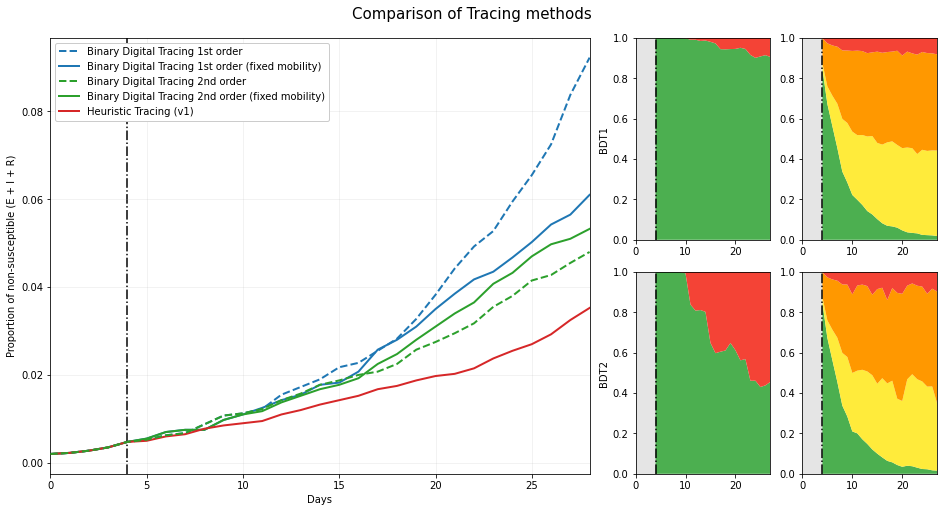

In [24]:
mean_bdt1_states = np.mean(bdt1_states[:, 1:4].sum(1), axis=0) # E + I + R
mean_bdt2_states = np.mean(bdt2_states[:, 1:4].sum(1), axis=0)
mean_heuristic_states = np.mean(heuristic_states[:, 1:4].sum(1), axis=0)

mean_bdt1_2_heuristic_states = np.mean(bdt1_2_heuristic_states[:, 1:4].sum(1), axis=0)
mean_bdt2_2_heuristic_states = np.mean(bdt2_2_heuristic_states[:, 1:4].sum(1), axis=0)

mean_bdt1_intervention_levels = np.mean(bdt1_intervention_levels, axis=0)
mean_bdt2_intervention_levels = np.mean(bdt2_intervention_levels, axis=0)

mean_bdt1_rec_levels = np.mean(bdt1_rec_levels, axis=0)
mean_bdt2_rec_levels = np.mean(bdt2_rec_levels, axis=0)

fig = plt.figure(figsize=(13, 7), constrained_layout=True)

gridspec = fig.add_gridspec(2, 6)

# Proportion of exposed plot
ax0 = fig.add_subplot(gridspec[:, :4])

ax0.grid(alpha=0.2, zorder=0)

legend_handles = [
    Line2D([0], [0], color='C0', lw=2, ls='--', label='Binary Digital Tracing 1st order'),
    Line2D([0], [0], color='C0', lw=2, label='Binary Digital Tracing 1st order (fixed mobility)'),
    Line2D([0], [0], color='C2', lw=2, ls='--', label='Binary Digital Tracing 2nd order'),
    Line2D([0], [0], color='C2', lw=2, label='Binary Digital Tracing 2nd order (fixed mobility)'),
    Line2D([0], [0], color='C3', lw=2, label='Heuristic Tracing (v1)')
]

ax0.plot(mean_bdt1_states, c='C0', ls='--', zorder=2, lw=2)
ax0.plot(mean_bdt1_2_heuristic_states, c='C0', zorder=2, lw=2)

ax0.plot(mean_bdt2_states, c='C2', ls='--', zorder=4, lw=2)
ax0.plot(mean_bdt2_2_heuristic_states, c='C2', zorder=2, lw=2)

ax0.plot(mean_heuristic_states, c='C3', zorder=2, lw=2)

ax0.set_xlim(0, 28)
ax0.axvline(4, c='k', ls='-.', zorder=0)
ax0.legend(handles=legend_handles, loc='upper left', framealpha=1.0)
ax0.set_xlabel('Days')
ax0.set_ylabel('Proportion of non-susceptible (E + I + R)')

# Mobility BDT1
legend_handles = [Patch(facecolor=color, edgecolor='k', label=f'Level {level}')
                  for (level, color) in enumerate(colors)]

ax1 = fig.add_subplot(gridspec[0, 4])
ax1.stackplot(np.arange(4, 4 + mean_bdt1_rec_levels.shape[1]),
              mean_bdt1_rec_levels, colors=colors)
ax1.axvspan(0, 4, fc='gray', alpha=0.2)
ax1.axvline(4, c='k', ls='-.')
ax1.margins(0, 0)
#ax1.set_title('Recommendation levels followed')
ax1.set_ylabel('BDT1')

# Mobility BDT2
ax2 = fig.add_subplot(gridspec[1, 4])
ax2.stackplot(np.arange(4, 4 + mean_bdt2_rec_levels.shape[1]),
              mean_bdt2_rec_levels, colors=colors)
ax2.axvspan(0, 4, fc='gray', alpha=0.2)
ax2.axvline(4, c='k', ls='-.')
ax2.margins(0, 0)
ax2.set_ylabel('BDT2')

# Mobility BDT1 (fixed)
ax3 = fig.add_subplot(gridspec[0, 5])
ax3.stackplot(np.arange(4, 4 + mean_bdt1_intervention_levels.shape[1]),
              mean_bdt1_intervention_levels, colors=colors)
ax3.axvspan(0, 4, fc='gray', alpha=0.2)
ax3.axvline(4, c='k', ls='-.')
ax3.margins(0, 0)
#ax3.set_title('Recommendation levels followed')

# Mobility BDT2 (fixed)
ax4 = fig.add_subplot(gridspec[1, 5])
ax4.stackplot(np.arange(4, 4 + mean_bdt2_intervention_levels.shape[1]),
              mean_bdt2_intervention_levels, colors=colors)
ax4.axvspan(0, 4, fc='gray', alpha=0.2)
ax4.axvline(4, c='k', ls='-.')
ax4.margins(0, 0)

plt.suptitle('Comparison of Tracing methods', size=15)

plt.show()

## Comparison of Tracing methods with different mobility

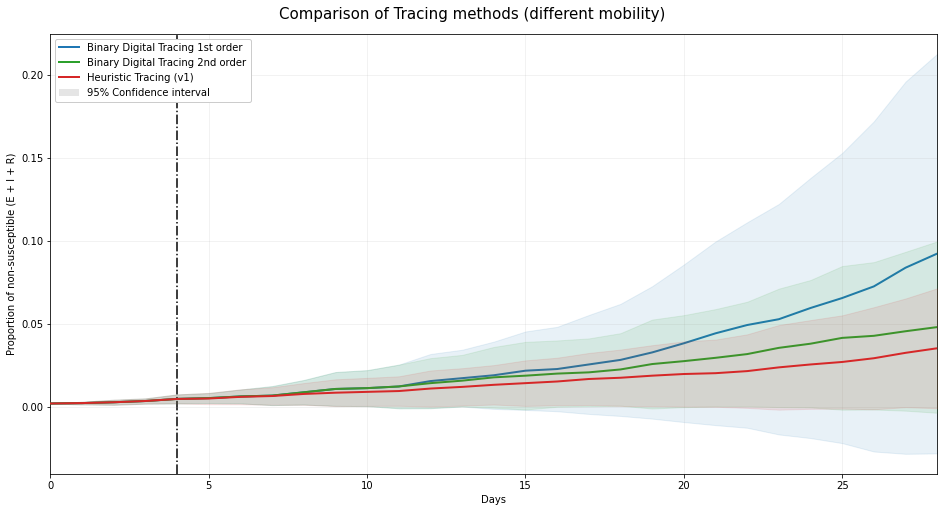

In [25]:
mean_bdt1_states = np.mean(bdt1_states[:, 1:4].sum(1), axis=0) # E + I + R
mean_bdt2_states = np.mean(bdt2_states[:, 1:4].sum(1), axis=0)
mean_heuristic_states = np.mean(heuristic_states[:, 1:4].sum(1), axis=0)

fig = plt.figure(figsize=(13, 7), constrained_layout=True)

gridspec = fig.add_gridspec(1, 1)

# Proportion of exposed plot
ax0 = fig.add_subplot(gridspec[0, 0])

ax0.grid(alpha=0.2, zorder=0)

legend_handles = [
    Line2D([0], [0], color='C0', lw=2, label='Binary Digital Tracing 1st order'),
    Line2D([0], [0], color='C2', lw=2, label='Binary Digital Tracing 2nd order'),
    Line2D([0], [0], color='C3', lw=2, label='Heuristic Tracing (v1)'),
    Patch(facecolor='gray', alpha=0.2, label='95% Confidence interval')
]

ax0.plot(mean_bdt1_states, c='C0', zorder=2, lw=2)
ax0.fill_between(np.arange(mean_bdt1_states.shape[0]),
                *ci(bdt1_states[:, 1:4].sum(1), level=0.95, axis=0),
                color='C0', alpha=0.1, zorder=1)

ax0.plot(mean_bdt2_states, c='C2', zorder=4, lw=2)
ax0.fill_between(np.arange(mean_bdt2_states.shape[0]),
                *ci(bdt2_states[:, 1:4].sum(1), level=0.95, axis=0),
                color='C2', alpha=0.1, zorder=3)

ax0.plot(mean_heuristic_states, c='C3', zorder=6, lw=2)
ax0.fill_between(np.arange(mean_heuristic_states.shape[0]),
                *ci(heuristic_states[:, 1:4].sum(1), level=0.95, axis=0),
                color='C3', alpha=0.1, zorder=5)

ax0.set_xlim(0, 28)
ax0.axvline(4, c='k', ls='-.', zorder=0)
ax0.legend(handles=legend_handles, loc='upper left', framealpha=1.0)
ax0.set_xlabel('Days')
ax0.set_ylabel('Proportion of non-susceptible (E + I + R)')

plt.suptitle('Comparison of Tracing methods (different mobility)', size=15)

plt.show()